<a href="https://colab.research.google.com/github/parseny/nlp_course/blob/2023/week10_efficiency/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Quantization

In this session, you're going to implement post-training quantization approaches for _Large Language Models_, ranging from naive ones to State of The Art techniques. The main goal is to implement [GPTQ](https://arxiv.org/abs/2210.17323), with some of it's newer extension left as bonus exercises.

<font color='red'>Important note:</font>
This homework is designed to run on colab with T4 gpu. It requires at least 15Gb of *VRAM*, 12Gb of *RAM*. If your machine meets those criteria, you should be good to go too.



# Installing the Dependencies

In [1]:
%%capture
%pip install transformers==4.35.0
%pip install sentencepiece==0.1.99
%pip install datasets==2.14.6
%pip install accelerate==0.24.1
%pip install Ninja==1.11.1.1

### Imports

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0 # Change it if you're on a multy-GPU machine

import os
import math
import random
from tqdm.notebook import tqdm, trange
from typing import Mapping
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig
from transformers import AutoTokenizer
from datasets import load_dataset

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0 # Change it if you're on a multy-GPU machine


# Quantizing Matrices Row-Wise

### Basic Quantization

**Mapping the values to the allowed range**

Quantization is the process of mapping input values from a large set to output values in a smaller set. For instance, if we consider 4-bit
quantization, our values are represented by $4$ bits, meaning we can represent values between 0 and $2^4-1=15$.

 * To produce the quantized representation, we need to be able to map the matrix values to and from this range.
 * For reasons that become important later, we will perform this mapping independently for each matrix row.
 * We will parametrize the mapping like this: $out = \frac{in}{scale} + zero$, where $scale$ and $zero$ are row-wise constants.
 * For a matrix of size `(m, k)` ($m$ rows, $k$ columns) we will aggregate those parameters into two vectors `scale` and `zero` of size `(m, 1)`.

**Task (1pt):** Complete the function below to perform this mapping:

In [7]:
def get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""

    min_val =  torch.min(x, dim=-1).values
    max_val = torch.max(x, dim=-1).values
    scale = (max_val - min_val) / max_abs
    scale[scale == 0] = 1
    zero = - min_val / scale
    return scale.unsqueeze(-1), zero.unsqueeze(-1)


In [8]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
assert scale.shape == (512, 1), "scale is wrong shape"
assert zero.shape == (512, 1), "zero is wrong shape"
assert torch.all(scale * 15 <= 1023.1), "Scale can't be that large. The resulting interval is too wide"
assert torch.all(scale * 15 >= 1022.9), "Scale shouldn't be that small. The resulting interval is too narrow"
assert torch.all(-0.001 <  x / scale + zero) and torch.all(x / scale + zero < 15 + 0.001)

x = torch.zeros(128, 128)
scale, zero = get_scale_and_zero(x, 15)
assert torch.all(scale == 1) and torch.all(scale * 15 >= 0.99), "If all the values in a row are identical, let us set scale to 1"
print("All tests passed!")

All tests passed!


**Quantization**

Having mapped the values into the allowed range, we can simply round them to obtain the quantized matrix. Complete the functions below to perform row-wise quantization. Note that:
 * You should `torch.clamp(...)` the quantized values to ensure that they are in the allowed range.
 * Some functions return the quantized matrix, as well as the quantization constants, because we'll need them to dequantize the matrix. Use `get_scale_and_zero` to obtain the them.
 * Note that we cast the quantized tensor to `uint8`, but the values themselves must be in the possibly narrower range, as determined by the number of bits. Obviously, we require the latter to be less or equal than 8.

**Task (1pt):** Complete the function below to perform quantization:

In [11]:
def quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Quantizes a tensor
    Args:
        x (Tensor): tensor to quantize
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero
        bits (int): number of bits to quantize to

    Returns:
        Tensor: quantized tensor in uint8
    """
    max_abs = 2 ** bits - 1
    quantized_x = torch.round(x / scale + zero)
    quantized_x = torch.clamp(quantized_x, 0, max_abs)
    return quantized_x.to(torch.uint8)


def dequantize(quantized_x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    """Dequantize a tensor
    Args:
        quantized_x (Tensor): quantized tensor in uint8
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero

    Returns:
        Tensor: dequantized tensor
    """
    dequantized_x = quantized_x * scale - zero * scale
    return dequantized_x


def measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    """Determine the values interval mapping parameters and quantize a tensor
    Args:
        x (Tensor): tensor to quantize
        bits (float): number of bits to quantize to

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized tensor, scale, zero
    """
    max_abs = 2 ** bits - 1
    scale, zero = get_scale_and_zero(x, max_abs)
    quantized_x = quantize(x, scale, zero, bits)
    return quantized_x, scale, zero


In [12]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
quantized_x, scale, zero = measure_and_quantize(x, 4)

assert quantized_x.shape == x.shape, "Shape of quantized_x is incorrect"
assert scale.shape == (512, 1), "Shape of scale is incorrect"
assert zero.shape == (512, 1), "Shape of zero is incorrect"
assert torch.all(quantized_x >= 0) and torch.all(quantized_x <= 15) and torch.any(quantized_x == 15), "wrong quantized_x values range"
assert torch.allclose(x, dequantize(quantized_x, scale, zero), atol=50), "Dequantized values are too far from the original values"
print("All tests passed!")

All tests passed!


**Using the quantized matrix**

To actually use the matrix, we'll have to map it's values back into their original form.

In [13]:
class QuantizedLinear(nn.Module):
    def __init__(self, quantized_weight, scale, zero, bias):
        super().__init__()
        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.scale = nn.Parameter(scale, requires_grad=False)
        self.zero = nn.Parameter(zero, requires_grad=False)
        self.bias = nn.Parameter(bias.data.clone().detach()) if bias is not None else None

    def forward(self, input):
        return F.linear(input, dequantize(self.quantized_weight, self.scale, self.zero), self.bias)


This class will be used as a replacement for `nn.Linear`. It holds the quantized weight and only dequantizes it during it's forward passes.

# LLM Quantization

### Preparations

Run all the cells in this subsection to download and prepare the model and the data

**Downloading the model**

Run the code below to download the model checkpoint.

In [14]:
!mkdir model

In [15]:
from huggingface_hub import snapshot_download

LLAMA_REPO = "Enoch/llama-7b-hf"
snapshot_download(repo_id=LLAMA_REPO, local_dir="./model")


Fetching 42 files:   0%|          | 0/42 [00:00<?, ?it/s]

'/content/model'

**Dispatching the model**

To properly quantize the model we'll need two functions.
 1. `initialize_layerless_llama` creates a llama model without any layers, but correct weights otherwise
 2. `load_and_dispatch_a_layer` loads a layer inserts it into the model after the last layer

In [16]:
# Disable fancy model initialization since we'll override those values anyway
def skip(*args, **kwargs):
    pass
torch.nn.init.kaiming_uniform_ = skip
torch.nn.init.uniform_ = skip
torch.nn.init.normal_ = skip


def initialize_layerless_llama(checkpoint_path):
    config = LlamaConfig.from_pretrained(LLAMA_REPO)
    config.num_hidden_layers=0

    model = LlamaForCausalLM(config)
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, "pytorch_model-00033-of-00033.bin")))
    model.seqlen = 2048
    model.config.use_cache = False

    return model.to(torch.float16)


def load_and_dispatch_a_layer(layer_idx, checkpoint_path, model: LlamaForCausalLM):
    if checkpoint_path == "TEST":
        linear = nn.Linear(16, 16)
        linear.weight.data = torch.arange(16 * 16).reshape(16, 16).float()
        model.model.layers.append(nn.ModuleDict({"submodule": linear}))
        return

    config = transformers.AutoConfig.from_pretrained(LLAMA_REPO)

    layer = LlamaDecoderLayer(config)
    layer_state_dict = torch.load(os.path.join(checkpoint_path, f"pytorch_model-{layer_idx + 1:05}-of-00033.bin"))
    layer_state_dict = {name[len(f"model.layers.{layer_idx}."):]: tensor for name, tensor in layer_state_dict.items()}
    layer.load_state_dict(layer_state_dict, strict=False)
    del layer_state_dict

    model.model.layers.append(layer.to(torch.float16))


Calling `initialize_layerless_llama` and then calling `load_and_dispatch_a_layer` for each layer in order would fully load the model, but we'll also quantize the layes as we go.

### RTN Quantization for LLaMA

**Auxiliary functions:**
 * `find_layers` takes a module and returns a dictionary containing all of it's *Linear* submodules with their path-names as the keys.
 * `replace_submodule` takes a module, a path-name and a submodule and replaces the module's submodule at path-name with the new submodule.

In [17]:
def find_layers(module: nn.Module, name='') -> dict[str, nn.Module]:
    if type(module) == nn.Linear:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)

**Load-Quantize cycle**

First, take a look at the function below. It uses the functions above to load the layers one by one and iterate over their `Linear` submodules replacing them with `QuantizedLinear`. A few things to keep in mind:
 * Note that the quantization happens on `.cuda()`, because we'll load *LLaMA* in `float16` which is not supported on `cpu`.
 * We call `torch.cuda.empty_cache()` after processing each layer because we'll have just enough *VRAM* for this to work.
 * The loaded model is placed in RAM.

**Task (1pt):** implement RTN quantization for *LLaMA*

In [20]:
@torch.no_grad()
def llama_rtn(checkpoint_path: os.PathLike, model: LlamaForCausalLM, bits: int):
    """Loads LLaMA layers one by one and quantizes them with RTN
    Args:
        checkpoint_path (os.PathLike): folder containing LLaMA weights
        model (LlamaForCausalLM): model to dispatch layers into
        bits (int): number of bits to quantize to
    """
    # Load and quantize all the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()

        linear_submodules = find_layers(layer)
        # Quantize the linear layers and replace the original ones with them
        for name, linear in linear_submodules.items():
            quantized_weight, scale, zero = measure_and_quantize(linear.weight.data, bits)
            quantized_layer = QuantizedLinear(quantized_weight, scale, zero, linear.bias)
            replace_submodule(layer, name, quantized_layer)
        layers[i] = layer.cpu()
        torch.cuda.empty_cache()


In [21]:
# Testing your code

model = nn.ModuleDict({"model": nn.ModuleDict({"layers": nn.ModuleList([])})})
llama_rtn("TEST", model, 4)

assert len(model.model.layers) == 32, "You didn't load all the layers"
assert all(isinstance(layer.submodule, QuantizedLinear) for layer in model.model.layers), "Some Linears weren't properly replaced"
assert torch.all(model.model.layers[0].submodule.quantized_weight == torch.arange(16).unsqueeze(0).repeat(16, 1)), "Quantized weights are weird"
assert torch.all(model.model.layers[0].submodule.scale == 1), "Quantized scales are weird"
print("All tests passed!")

  0%|          | 0/32 [00:00<?, ?it/s]

All tests passed!


### Testing the Quantized Model

Now we have everything we need to quantize the _LLaMA-7B_ model to 4 bits. Let us do that.

In [22]:
MODEL = "./model/"
SEED = 0
BITS = 4

In [23]:
tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

model = initialize_layerless_llama(MODEL)
llama_rtn(MODEL, model, BITS)
model = model.cuda()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


  0%|          | 0/32 [00:00<?, ?it/s]

In [24]:
questions = [
    "What is the capital of France?",
    "Can you explain the Pythagorean theorem?",
    "What is photosynthesis?",
    "Give me a summary of 'Romeo and Juliet'",
    "How far is the moon from the Earth?",
    "What is a haiku?",
]
answers = []

for question in tqdm(questions):
    tokenized_input = tokenizer(
        f"QUESTION: {question}\n ANSWER:",
        return_tensors="pt"
    )
    with torch.no_grad():
        output = model.generate(
            tokenized_input["input_ids"].cuda(),
            max_length=50, num_beams=3, early_stopping=True,
        )[0]
    answer = tokenizer.decode(output, skip_special_tokens=True)
    answers.append(answer[:answer.find(".")] + ".")


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [25]:
print(*answers, sep="\n\n")

QUESTION: What is the capital of France?
 ANSWER: Paris.

QUESTION: Can you explain the Pythagorean theorem?
 ANSWER: The Pythagorean theorem states that the sum of the squares of the sides of a right triangle is equal to the square o.

QUESTION: What is photosynthesis?
 ANSWER: Photosynthesis is the process by which plants use the energy of sunlight to convert carbon dioxide and water into carbohydrates an.

QUESTION: Give me a summary of 'Romeo and Juliet'
 ANSWER: Romeo and Juliet is a tragedy written by William Shakespeare about two young star-crossed lovers, Rom.

QUESTION: How far is the moon from the Earth?
 ANSWER: About 240,000 miles.

QUESTION: What is a haiku?
 ANSWER: A haiku is a form of Japanese poetry that consists of three unrhymed lines of 5, 7, and 5 syllables.


In [26]:
model = model.cpu()
torch.cuda.empty_cache()

### Evaluating the model

Before we start quantizing the model itself, let us create a way to evaluate it's performance.


**Downloading the data**

As a metric of the models' performance, we'll use it's PPL on the [wikitext2](https://paperswithcode.com/dataset/wikitext-2) dataset. Let us download and tokenize it. We'll need two subsets of it:
 * Test set of size ... to evaluate the models.
 * A train subset of size ... that we'll use later for GPTQ.

In [27]:
SEED = 0

def get_wikitext2(seed, seqlen, nsamples=128):
    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

    train_input_ids = tokenizer("\n\n".join(traindata['text']), return_tensors='pt').input_ids
    random.seed(seed)
    train_batch = []
    for _ in range(nsamples):
        i = random.randint(0, train_input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = train_input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        train_batch.append(inp[0])

    test_input_ids = tokenizer("\n\n".join(testdata['text']), return_tensors='pt').input_ids
    test_input_ids = test_input_ids[:, :(test_input_ids.shape[1] // seqlen) *  seqlen]
    test_input_ids = test_input_ids.reshape(test_input_ids.shape[1] // seqlen, seqlen)

    return torch.stack(train_batch), test_input_ids

train_batch, test_input_ids = get_wikitext2(SEED, 2048)

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

**Model offloading**

We want to evaluate the model's performance on a large dataset. The model barely fits on the *GPU*, and we'll have to infer in on long text sequences. We don't have enought *VRAM* to do that.

Instead, we'll keep most of the model in *RAM*, only transferring the layers to *GPU* as we go through them one by one, and putting them back when we're done.

**Obtaining the first layer inputs**

To start iterating over the layers, we'll first have to obtain the fist layer inputs. We use the function below to do it.

In [28]:
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/utils.py --no-check-certificate

--2023-12-07 20:38:29--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1334 (1.3K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.30K  --.-KB/s    in 0s      

2023-12-07 20:38:30 (71.2 MB/s) - ‘utils.py’ saved [1334/1334]



In [29]:
from utils import get_first_layer_inputs

In [30]:
class TestModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({"layers": nn.ModuleList([])})

    def forward(self, inp):
        self.model.layers[0](2 * inp, attention_mask="Some Mask", position_ids="Some Ids")


test_model = TestModule()
llama_rtn("TEST", test_model, 4)
test_inputs = torch.arange(16 * 32).reshape(16, 32).float()
hidden_states, attention_mask, position_ids = get_first_layer_inputs(test_model, test_inputs)
assert torch.all(2 * test_inputs == hidden_states)
assert attention_mask == "Some Mask"
assert position_ids == "Some Ids"
assert len(test_model.model.layers) == 32, "The function doesn't put back the original layers"
print("All tests passed!")

  0%|          | 0/32 [00:00<?, ?it/s]

All tests passed!


**Forward passing layer-by-layer**

In [31]:
def forward_pass_layer(layer: nn.Module, inps: torch.Tensor, outs: torch.Tensor, attention_mask: Tensor, position_ids: Tensor):
    """Forward pass inps through the layer ONE INP AT A TIME saving the outputs into the corresponding elements of outs"""
    for j in range(inps.shape[0]):
        outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask, position_ids=position_ids)[0]


def get_batch_nll(model: nn.Module, batch: Tensor):
    # Collect the first layer inputs, put them on .cuda()
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 32
    for i in trange(32, leave=False):
        layer = layers[i].cuda() # Take a layer and put in on .cuda()

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids) # Forward pass a layer
        inps, outs = outs, inps # Prepare the inputs and the output buffer for the next layer. Reuse the existing buffers

        layers[i] = layer.cpu() # Put layer back on .cpu()
        del layer
        torch.cuda.empty_cache()


    # Calculate NLL
    nll = 0
    model.model.norm = model.model.norm.cuda()
    model.lm_head = model.lm_head.cuda()
    for i in range(inps.shape[0]):
        lm_logits = model.lm_head(model.model.norm(inps[i].unsqueeze(0)))
        labels = batch[i]
        # Calculate the language modeling Negative Log Likelyhood
        shift_logits = lm_logits[:, :-1, :]
        shift_labels = labels[1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).cuda())
        nll += float(loss) * model.seqlen
    model.model.norm = model.model.norm.cpu()
    model.lm_head = model.lm_head.cpu()
    return nll


@torch.no_grad()
def llama_eval(model, test_input_ids):
    print('Evaluating ...')

    total_nll = 0
    for batch in tqdm(torch.tensor_split(test_input_ids, 4)):
        total_nll += get_batch_nll(model, batch)

    # Calculate PPL
    ppl = math.exp(total_nll / test_input_ids.numel())
    print(f"PPL: {ppl}")
    return ppl


**Calculating PPL**

We've already loaded and quantized the model. All that's left is to evaluate it.

In [32]:
rtn_ppl = llama_eval(model, test_input_ids)

Evaluating ...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

PPL: 6.429360908668111


In [34]:
# Testing your code

assert rtn_ppl > 6.3 and rtn_ppl < 6.6
print("All tests passed!")

All tests passed!


In [33]:
del model
torch.cuda.empty_cache()

### GPTQ

GPTQ is the State Of The Art quantization algorithm for post-training DL model quantization. It works by sequentially quantizing the model's linear layer weights.

Although in outputs results similar to what one would get with Round To Nearest quantization, it makes a key observations to boost it's end performance:
 * It is layer input aware (also referred to as "1-Shot" method), meaning int optimizes the quantized matrix to show best performance on inputs typically encountered in that layer.
More formally, the problem can be formulated as:
$$
W_q = argmin_{\widehat{W}}\|XW^T - X\widehat{W}^T\|_2^2
$$
, where
 * $X$ is the input matrix of shape `(..., IN)`.
 * $XW^T$ is the unquantized output of shape `(..., OUT)`. We think of the norm above as taking a sum over those (...) dimensions.
 * $W$ is the unquantized weight of shape `(OUT, IN)`.
 * $\widehat{W}$ is the quantized weight taken from some quantization grid.

One can notice that the expression above is independent with regard to the rows of $W$ and $\widehat{W}$, meaning we can solve it for each row in parallel. This is the reason why we're working with row-wise quantization in the first place. Notice that the quantization grid only depends on min/max values withing the row and not the quantization process, so we can think of it as fixed.

and the dimension of the optimization problem is `IN`, which is too much to solve exactly. The algorithm proposes to solve it iteratively.

Less us consider a vector of full precision weights $F$ and corresponding sent of inputs $X_F$. The corresponding objective is quadratic with Hessian
$$
H_F = 2X_F^TX_F^.
$$
The algorithm can be described like this:
 * Do the following steps until $F$ is fully quantized:
    1. Given the next index to quantize $i$, and corresponding unquantized element $F_i$.
    2. Quantize the coordinate by prjecting in onto the quantization grid $Q_i = quant(F_i)$.
    3. Update all of the remaining weights $F_: = F_: - \frac{F_i - quant(F_i)}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,:}$.
    4. Exclude $i$ from $F$.

It uses the inverse Hessian to slightly tune the remaining unquantized weights to mitigate the quantization error.

As for how $i$ is chosen, an observation was made that iterating over indices in order of **decreasing diagonal Hessian elements** provides the best performance.

There are a few more ideas that make this algorithm much faster:
 1. We can represent the order of quantization (selection of $i$) by permuting the row in advance, and then iterating over the row element in order.
 $$
   F_{i:} = F_{i:} - \frac{F_{i} - quant(F_{i})}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,i:}
 $$
 2. The problem is row-wise independent, meaning that we use the same permutation each row and perform those operations in a vector fashion for all the rows at the same time.
 $$
   F_{:,i:} = F_{:,i:} - \frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\odot\left[H_F^{-1}\right]_{i,i:}\leftarrow\text{\textbf{ you'll have to code this}}
 $$
 3. We don't actually need to recompute the inverse Hessian. At $i$-th step we only need its $t$-th row, and we can use fancy math to precompute the matrix containing all of those rows in advance.
 $$
  H^{-1} = Cholesky(H^{-1})^T    
 $$

 4. We don't need to tune all the remaining unquantized values right away. We can only apply the updates for the closest elements right away and accumulate all the other updates to apply them only once in a while.

    We'll do this in block of fixed size, applying the updates inside of those blocks and updating the weights outside only when we're done with the block. To accumulate those updates, we'll collect the scaled quantization error
    $$
      Err_{:,i} =\frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\text{ for all }i\text{ in block}.
    $$

**GPTQ within blocks**

Implement GPTQ within the block. Iterate over the columns in ordered vector fashion, quantizing them one by one and updating all the remaining colums within the block.

Return the quantized weight as well as the matrix of quantization errors that we'll need to tune the unquantized weights outside of the block.

**Task (2pt):** Implement GPTQ block:

In [ ]:
@torch.no_grad()
def gptq_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """Perform GPTQ within block
    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constats of shape (OUT, 1)
        zero (Tensor): row-wise quantization constats of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    block_weight = block_weight.clone()
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.uint8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Interate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        # YOUR CODE HERE>>>>>>>>>
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error


In [ ]:
# Testing your code
!wget -O gptq_block_weight_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_block_weight_reference.pt --no-check-certificate
!wget -O gptq_block_error_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_block_error_reference.pt --no-check-certificate

generator = torch.Generator()
generator.manual_seed(0)

weight = torch.rand((128, 128), generator=generator).cuda()
scale, zero = get_scale_and_zero(weight, 15)

block_weight = weight[:,:16]

block_hessian_inverse = (torch.triu(torch.rand((16, 16), generator=generator), diagonal=1) + torch.diag(torch.rand(16, generator=generator) + 1)).cuda()
quantized_block_weight, scaled_block_error = gptq_block(block_weight, block_hessian_inverse, scale, zero, 4)

assert torch.all(quantized_block_weight == torch.load("gptq_block_weight_reference.pt"))
assert torch.allclose(scaled_block_error, torch.load("gptq_block_error_reference.pt"), rtol=1e-5, atol=1e-06)

print("All tests passed!")

**Now we can implement the full algorithm:**
 * Get row-wise quantization constants.
 * Sort the columns by decreasing Hessian diagonal values. Think about how you'd have to permute the Hessian as well.
 * Process the Hessian to obtain the precomputed inverse Hessian.
 * Iterate over the columns in blocks:
    * Get the next block and quantize it.
    * Tune all the following blocks to mitigate the quantization error.
      $$
         F_{:,block\_end:} = F_{:,block\_end:} - Err_{:,block\_start:block\_end}\odot\left[H_F^{-1}\right]_{block\_start:block\_end,block\_end:}
      $$
 * Restore the original order for quantized columns.

**Task (2pt):** implement the full algorithms:

In [ ]:
def prepare_inverse_hessian(hessian: Tensor, percdamp: float) -> Tensor:
    """Precomputes inverse Hessian
    Args:
        hessian (Tensor): problem hessian
        percdamp (float): diagonal damping constant for numerical stability
    Returns:
        Tensor: precomputed inverse Hessian
    """
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(hessian.shape[0], device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    return hessian


@torch.no_grad()
def gptq(weight: torch.Tensor, bits: int, hessian: torch.Tensor, blocksize:int=128, percdamp:float=.01) -> tuple[Tensor, Tensor, Tensor]:
    """Quantizes weight with GPTQ
    Args:
        weight (torch.Tensor): weight to quantize
        bits (int): number of bits to quantize to
        hessian (torch.Tensor): problem Hessian
        blocksize (int, optional): Defaults to 128.
        percdamp (float, optional): Hessian damping constant for numerical stability. Defaults to .01.

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized_weight, row-wise quantization scales, row-wise quantization zeroes
    """
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()
    num_columns = weight.shape[1]
    hessian = hessian.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Get row-wise quantization constants
    scale, zero = get_scale_and_zero(weight, 2 ** bits - 1)

    # Sort the columns by decreasing Hessian diagonal values.
    # Transform the hessian accordingly.
    # YOUR CODE HERE>>>>>>>>>
    perm =
    invperm =
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Process the Hessian to obtain the precomputed inverse Hessian
    hessian_inverse = prepare_inverse_hessian(hessian, percdamp)

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.uint8, device=weight.device)
    for block_start in range(0, num_columns, blocksize):

        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        # YOUR CODE HERE>>>>>>>>>

        # Tune all the following blocks to mitigate the quantization error

        # <<<<<<<<<<<<<<<<<<<<<<<

    # Reverse the permutation of the quantized weight
    quantized_weight = quantized_weight[:, invperm]

    return quantized_weight, scale.to(dtype), zero.to(dtype)


In [ ]:
# Testing your code
!wget -O gptq_weight_reference.pt https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/gptq_weight_reference.pt --no-check-certificate

generator = torch.Generator()
generator.manual_seed(0)

hessian = torch.triu(torch.rand((128, 128), generator=generator) + 4 * torch.eye(128)).cuda().half()
hessian += hessian.clone().T
quantized_weight, _, _ = gptq(weight, 4, hessian, 32)

assert torch.all(quantized_weight == torch.load("gptq_weight_reference.pt"))

print("All tests passed!")

**Sequential Model Quantization**

The GPT quantization approach implemented here requires an ordered approach due to its input-dependent nature. For each `Linear` submodule within the GPT model, we need to ensure that the input data is representative of the actual operating conditions post-quantization. This involves propagating a batch of input samples through the model sequentially, with each layer's input being the output of the preceding **quantized** layers.

The quantization process must follow a strict sequence both across and within layers. Within each layer, there is a predetermined order in which the submodules must be quantized, which is dictated by the dependencies between them. This order is defined by the "sequential groups".

The steps of the algorithm are as follows:
- Retrieve and prepare inputs for the first layer.
- Iterate through each layer in the model:
  - Load the current layer for processing.
  - Within each layer, process the sequential groups of submodules:
    - Attach forward hooks to collect input data to each submodule.
    - Execute a forward pass through the layer to accumulate the necessary input data for quantization.
    - Remove the hooks after data collection.
    - Apply GPTQ to quantize the submodule weights using the accumulated input data.
  - Perform another forward pass through the quantized layer to generate the inputs for the next layer.

In [ ]:
def get_accumulate_input_fn(name: str, hessians: Mapping[str, Tensor], num_samples: Mapping[str, int]):
    """Generate a callback that updates the corresponding hessians and counts when given input
    Args:
        name (str): module name
        hessians (Mapping[str, Tensor]): a dict of modules' hessians, accessible by module name
        num_samples (Mapping[str, int]): a dict of callback call counters
    """
    def tmp(_, inp, out):
        inp = inp[0].data # ... x hidden_size
        inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
        inp = inp.t().float() # hidden_size x inputs
        num_samples[name] += 1
        if hessians[name] is None:
            hessians[name] = inp.matmul(inp.t())
        else:
            hessians[name] += inp.matmul(inp.t())
    return tmp


@torch.no_grad()
def llama_gptq(checkpoint_path: os.PathLike, model: LlamaForCausalLM, batch: Tensor, bits: int):
    """Loads LLaMA layers one by one and quantizes them with GPTQ
    Args:
        checkpoint_path (os.PathLike): folder containing LLaMA weights
        model (LlamaForCausalLM): model to dispatch layers into
        batch (Tensor): sample model inputs
        bits (int): number of bits to quantize to
    """
    # Collect the first layer inputs, put them on .cuda() (the same as in get_batch_nll)
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        # Load and dispatch the next layer
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()
        linear_layers = find_layers(layer)

        hessians = {name: None for name in linear_layers}
        num_samples = {name: 0 for name in linear_layers}
        handles = [
            linear_layers[name].register_forward_hook(
                get_accumulate_input_fn(name, hessians, num_samples)
            ) for name in linear_layers
        ]
        forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
        for h in handles:
            h.remove()

        for name, linear in linear_layers.items():
            q, scale, zero = gptq(linear.weight.data, bits, 2 * hessians[name] / num_samples[name])
            quantized_linear = QuantizedLinear(q, scale, zero, linear.bias)
            replace_submodule(layer, name, quantized_linear)

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
        inps, outs = outs, inps
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()


**Evaluating the model with GPTQ**

**Task (2pt):** achieve the required PPL

In [ ]:
model = initialize_layerless_llama(MODEL)
llama_gptq(MODEL, model, train_batch, BITS)

In [ ]:
gptq_ppl = llama_eval(model, test_input_ids)

In [ ]:
# Testing your code

assert gptq_ppl < 6.2
print("All tests passed!")

In [ ]:
del model
torch.cuda.empty_cache()

# Dense Integer Packing

For the most part, we used `torch.uint8` to represent tensors quantized to *4 bits*. We encoded each *4-bit* value with an *8-bit* value, using twice as much memory as we really needed. We did this because `torch` lacks support for 4-bit tensors. However, we never performed any native operations in *8 bits*; we always converted it to `torch.float16` first. That means we can design a more efficient way to encode *4-bit* tensors and convert to and from it.

Your task is to implement these conversions, converting *8-bit* tensors containing *4-bit* values (the way we used to store quantized weights) to and from smaller *8-bit* tensor, utilizing the whole range of values. Moreover, you'll have to do it in a way such that memory representation of contiguous arrays wouldn't change. That is, adjacent columns get squashed together.

**Task (1pt):** Implement dense *int4*:

In [ ]:
def dense_pack_4_8(x: Tensor) -> Tensor:
    """Constructs a densely packed int tensor
    Args:
        x (Tensor): uint8 with uint4 values range
        real_bits (int): real values range of the tensor

    Returns:
        Tensor: twice as small uint8 tensor with uint8 values range
    """
    x = x.clone().detach()
    # YOUR CODE HERE>>>>>>>>>
    # <<<<<<<<<<<<<<<<<<<<<<<

def dense_unpack_4_8(x: Tensor) -> Tensor:
    """Deconstructs a densely packed int tensor
    Args:
        x (Tensor): uint8 tensor with uint8 values range

    Returns:
        Tensor: twice as large int8 tensor with uint4 values range
    """
    x = x.clone().detach()
    # YOUR CODE HERE>>>>>>>>>
    # <<<<<<<<<<<<<<<<<<<<<<<


In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
quantized_x, scale, zero = measure_and_quantize(x, 4)
dense_quantized_x = dense_pack_4_8(quantized_x)
undense_quantized_x = dense_unpack_4_8(dense_quantized_x)

assert dense_quantized_x.shape == (512, 512)
assert torch.all(undense_quantized_x == quantized_x)
assert (dense_quantized_x // 16 == dense_quantized_x % 16).float().mean() > 0.95, "close values are supposed to be packed together"
print("All tests passed!")

# Bonus: QUIK

[QUIK](https://arxiv.org/abs/2310.09259) is an extension of GPTQ. It's main feature is that, in addition to model quantization, it also quantizes activations. That way, multiplication can be performed in `int`, leading to 2x-3x improvement in inference speed over GPTQ, which dequantizes the weights and performs multiplication in `float`.

### Different Range, Different Scales and Zeros

At basic quantization level, QUIK already has a number of differences compared to GPTQ:
 1. QUIK quantizes the weights to **signed** integer values for better stability of matrix multiplication.
 2. QUIK enforces `zero` to be integer, to be able to perform `int` multiplication with it as well.
 3. QUIK changes the sign of `zero` (compare `quik_dequantize` with `dequantize`) for simplicity.

In [ ]:
def quik_get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    if x.shape[-1] == 0:
        return torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device), torch.zeros(x.shape[:-1], dtype=torch.int, device=x.device)
    xmin = x.min(-1)[0]
    xmax = x.max(-1)[0]

    scale = (xmax - xmin) / max_abs / 2
    scale[scale == 0] = 1
    zero = torch.round((xmax + xmin) / 2 / scale) # zero is int, since we want to use it in int operations

    return scale.unsqueeze(-1), zero.unsqueeze(-1).to(torch.int)


def quik_quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Given a tensor x quantize it, producing tensors quantized_x of torch.int8 dtype
    Args:
        x (Tensor): tensor to quantize
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero
        bits (int): number of bits to quantize to

    Returns:
        Tensor: quantized tensor in int8
    """
    if x.shape[-1] == 0:
        return torch.zeros(x.shape, dtype=torch.int8, device=x.device)
    max_abs = 2 ** (bits - 1) - 1
    quantized_x = torch.round(x / scale) - zero
    quantized_x = torch.clamp(quantized_x, -max_abs, max_abs) # what are the allowed values for int8?
    return quantized_x.to(torch.int8)


def quik_dequantize(x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    """Dequantize a tensor
    Args:
        quantized_x (Tensor): quantized tensor in int8
        scale (Tensor): values interval mapping scale
        zero (Tensor): values interval mapping zero

    Returns:
        Tensor: dequantized tensor
    """
    return scale * x + scale * zero


def quik_measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    """Determine the values interval mapping parameters and quantize a tensor
    Args:
        x (Tensor): tensor to quantize
        bits (float): number of bits to quantize to

    Returns:
        tuple[Tensor, Tensor, Tensor]: quantized tensor, scale, zero
    """
    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(x, max_abs)
    x_quantized = quik_quantize(x, scale, zero, bits)
    return x_quantized, scale, zero


In [ ]:
# Testing my code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = quik_get_scale_and_zero(x, 15)
quantized_x, scale, zero = quik_measure_and_quantize(x, 4)

assert scale.shape == (512, 1), "Shape of scale is incorrect"
assert zero.shape == (512, 1), "Shape of zero is incorrect"
assert torch.allclose(x, quik_dequantize(quantized_x, scale, zero), atol=50), "Dequantized values are too far from the original values"
print("All tests passed!")

All tests passed!


### Weight Quantization

**Block quantization**

On block level, QUIK is identical to GPTQ. Paste your `gptq_block` solution here and simply replace `quantize` with `quik_quantize` and `dequantize` with `quik_dequantize`.

**Task (1pt):** Paste GPTQ code into QUIK:

In [ ]:
@torch.no_grad()
def quik_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """NOTE: This function is allowed to alter the block_weight as we won't need those weights anymore

    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constants of shape (OUT, 1)
        zero (Tensor): row-wise quantization constants of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    block_weight = block_weight.clone()
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.int8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Iterate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        # YOUR CODE HERE>>>>>>>>>
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error


**Full quantization**

To determine the outliers, QUIK needs additional information about layer inputs. Namely, `l_inf_norms` - max module values for each input coordinate in a minibatch. We can see how it's used to extract outliers.

The rest of the function, again, is copy-paste from `gptq(...)`. Feel free to reuse your code, but don't forget to replace `gptq_block` with `quik_block`.

**Task (1pt):** Paste GPTQ code into QUIK:

In [ ]:
def quik(weight: torch.Tensor, bits: int, hessian: torch.Tensor, l_inf_norms: torch.Tensor, blocksize:int=128, percdamp:float=.01, n_outliers=128):
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Identify outliers by decreasing l_inf_norms. Sort the remained by decrasing hessian values
    perm = torch.argsort(l_inf_norms, descending=True)
    perm[n_outliers:] = perm[n_outliers:][torch.argsort(torch.diag(hessian)[perm][n_outliers:], descending=True)]
    weight = weight[:, perm]
    hessian = hessian[perm, :][:, perm]

    # Process outliers
    outlier_weight = weight[:,:n_outliers]
    weight = weight[:,n_outliers:]
    num_columns = weight.shape[1]
    hessian = hessian[n_outliers:,:][:,n_outliers:]

    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(weight, max_abs)

    # Process the Hessian to obtain the precomputed inverse Hessian
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(num_columns, device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    hessian_inverse = hessian

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.int8, device=weight.device)
    for block_start  in range(0, num_columns, blocksize):
        block_end = min(block_start + blocksize, num_columns)

        # YOUR CODE HERE>>>>>>>>>
        # Get the next block and quantize it

        # Tune all the following blocks to mitigate the quantization error

        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_weight, scale.to(dtype), zero, outlier_weight.to(dtype), perm

### QUIK Linear Layer

**Install CUDA 12.3 and cutlass**

In [ ]:
%%capture
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/12.3.0/local_installers/cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu2204-12-3-local/cuda-*-keyring.gpg /usr/share/keyrings/
!sudo apt-get update
!sudo apt-get -y install cuda-toolkit-12-3
!pip install --upgrade pip

!git clone https://github.com/NVIDIA/cutlass.git
!export CUDACXX=/usr/local/cuda/bin/nvcc
!cd cutlass && mkdir build && cd build && cmake .. -DCUTLASS_NVCC_ARCHS=75

**Loading custom CUDA kernels**

Along with this jupyter notebook, two `CUDA` files are provided, implementing efficient matrix multiplication for `int4` and `int8`.

In [ ]:
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/kernel.cpp --no-check-certificate
!wget -nc https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week10_efficiency/kernel.cu --no-check-certificate

In [ ]:
from torch.utils.cpp_extension import load

custom_kernel = load(name='custom_kernel', sources=['kernel.cpp', 'kernel.cu'], extra_include_paths=[r"cutlass/include"])

Usage: `output = custom_kernel.int8_matmul(X, Y)` and `output = custom_kernel.int4_matmul(X, Y)` compute $XY^T$ (same as `nn.functional.linear`).

Notice that `int8_matmul` takes the normal `torch.int8` tensors, but int4_matmul expects `int4` values densely packed into `torch.uint8` tensors. This is exactly what we wrote **Dense Integer Packing** for. They have a <font color='red'>severe limitation</font>: the dimension of multiplication must be divisible by 16.

Now you have to implement the quantized forward pass:

 $$
 \begin{align}
    XW^T &= (Q_x \cdot scale_x + zero_x \cdot scale_x)(Q_w \cdot scale_w + zero_w \cdot scale_w)^T =\\
    &= (Q_x  + zero_x)(Q_w + zero_w)^T \cdot (scale_x \odot scale_w^T) =\\
    &= (Q_xQ_w^T + Q_x zero_w^T + zero_x Q_w^T + zero_x zero_w^T) \cdot (scale_x \odot scale_w^T)
 \end{align}
 $$

because of the kernel limitations mentioned above, only the largest integer multiplication ($Q_xQ_w^T$) can be done in `int`. Perform the other ones in `float`.

**Task (3pt)**: implement QUIK forward pass and measure it's performance:

In [ ]:
class QuikLinear(nn.Module):
    def __init__(self, quantized_weight, weight_scale, weight_zero, outlier_weight, bias, bits: int, perm):
        super().__init__()
        self.bits = bits
        self.perm = perm
        self.n_outliers = outlier_weight.shape[1]

        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.weight_scale = nn.Parameter(weight_scale, requires_grad=False)
        self.weight_zero = nn.Parameter(weight_zero, requires_grad=False)

        self.outlier_weight = nn.Parameter(outlier_weight, requires_grad=False)
        self.weights_reduced = self.quantized_weight.to(torch.int32).sum(dim=1).float()

        if bias is not None:
            self.bias = nn.Parameter(bias.data.clone().detach())
        else:
            self.bias = None

    def forward(self, input):
        out_size, in_size = self.quantized_weight.shape
        input = input[...,self.perm]
        input_quantized, input_scale, input_zero = quik_measure_and_quantize(input[...,self.n_outliers:], self.bits)

        outliers_result = F.linear(input[...,:self.n_outliers], self.outlier_weight, self.bias)
        if input_quantized.shape[-1] == 0:
            return outliers_result

        # Convert necessary components to float
        inputs_reduced = input_quantized.to(torch.int32).sum(dim=-1).float()
        input_zero = input_zero.float()
        weight_zero = self.weight_zero.data.float()

        # Fully int operations
        # YOUR CODE HERE>>>>>>>>>
        quantized_result =
        quantized_result = quantized_result.float()
        # <<<<<<<<<<<<<<<<<<<<<<<

        # I wish those were int, but float operations
        # YOUR CODE HERE>>>>>>>>>
        quantized_result +=
        quantized_result +=
        quantized_result +=
        quantized_result =
        # <<<<<<<<<<<<<<<<<<<<<<<

        quantized_result = quantized_result.to(torch.float16)
        results = quantized_result + outliers_result
        return results

### Loading the First LLaMA Layer Attention Q Projection

In [ ]:
model = initialize_layerless_llama(MODEL)
inps, _, _ = get_first_layer_inputs(model, train_batch)
inps = inps.cuda()
model.model.layers = nn.ModuleList()
load_and_dispatch_a_layer(0, "./model", model)
layer = model.model.layers[0].self_attn.q_proj.cuda()
del model
torch.cuda.empty_cache()

### Gathering the Layer Inputs

In [ ]:
class AccumulatedInput:
    hessians = None
    num_samples = 0
    actnorms = None

@torch.no_grad()
def accumulate_layer_input(_, inp, out):
    inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
    inp = inp.t().float() # hidden_size x inputs
    AccumulatedInput.num_samples += 1
    if AccumulatedInput.hessians is None:
        AccumulatedInput.hessians = inp.matmul(inp.t())
        AccumulatedInput.actnorms = inp.abs().amax(dim=1)
    else:
        AccumulatedInput.hessians += inp.matmul(inp.t())
        AccumulatedInput.actnorms = torch.maximum(AccumulatedInput.actnorms, inp.abs().amax(dim=1))


for inp in inps:
    accumulate_layer_input(None, inp, None)

In [ ]:
OUT = layer.weight.shape[0]

In [ ]:
with torch.no_grad():
    reference = torch.stack(tuple(layer(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

### Benchmarking MSE

In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = measure_and_quantize(layer.weight.data, 8)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    rtn_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", rtn_mse)

assert rtn_mse < 8e-5 and rtn_mse > 7e-5

MSE: 7.630504842381924e-05


In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = gptq(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    gptq_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", gptq_mse)

assert gptq_mse < 3e-5 and gptq_mse > 1.5e-5

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=0)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_0_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_0_mse)

assert quik_0_mse < 6e-5 and quik_0_mse > 5e-5

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=256)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_256_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_256_mse)

assert quik_256_mse < 4.25e-5 and quik_256_mse > 3.25e-5

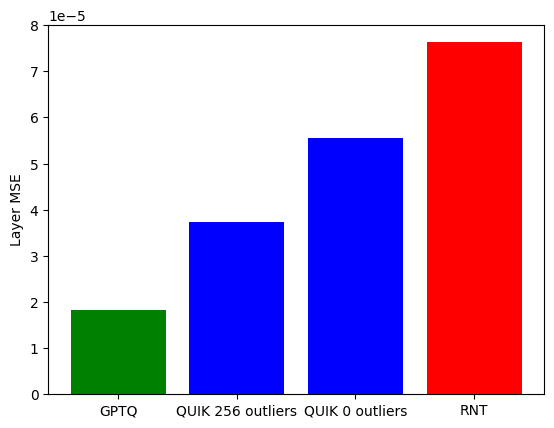

In [ ]:
fruits = ['GPTQ', 'QUIK 256 outliers', 'QUIK 0 outliers', 'RNT']
counts = [gptq_mse, quik_256_mse, quik_0_mse, rtn_mse]
bar_labels = ['green', 'blue', 'blue', 'red']
bar_colors = ['green', 'blue', 'blue', 'red']

plt.bar(fruits, counts, label=bar_labels, color=bar_colors)
plt.ylabel("Layer MSE")
plt.show()

As we can see, QUIK allows for errors smaller than RTN despite utilizing quantized activations, and addition of outliesr further decreases the error, bringing it closer to GPTQ. As we have seen in `benchmark.ipynb`, `int` matmul can lead to 2x-3x speedup over `float16`.